In [1]:
!pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 

In [2]:
from datasets import load_dataset, load_from_disk
import os
from google.colab import drive


drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Artificio_WikiArt'


if not os.path.exists(dataset_path):
    dataset = load_dataset("Artificio/WikiArt")
    dataset.save_to_disk(dataset_path)
else:
    dataset = load_from_disk(dataset_path)


print(dataset)


train_dataset = dataset['train']
print(train_dataset)


for example in train_dataset[:5]:
    print(example)

Mounted at /content/drive
DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
        num_rows: 103250
    })
})
Dataset({
    features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
    num_rows: 103250
})
title
artist
date
genre
style
description
filename
image
embeddings_pca512


In [3]:
import torch, os, json, tqdm, shutil, random, re, evaluate
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


In [4]:
def set_reproducibility(seed = 42) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_reproducibility()

In [5]:
import io

def plot_random_samples(df, num_samples=4, rows=2, cols=2):
    indices = random.sample(range(len(df)), num_samples)
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{row['title']} - {row['artist']}" for idx, row in df.iloc[indices].iterrows()])

    for i, idx in enumerate(indices):
        image_bytes = df.iloc[idx]['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes))
        row = i // cols + 1
        col = i % cols + 1
        fig.add_trace(go.Image(z=np.array(image)), row=row, col=col)
        fig.update_xaxes(showticklabels=False, row=row, col=col)
        fig.update_yaxes(showticklabels=False, row=row, col=col)

    fig.update_layout(
        title=dict(
            text='Random Samples from Dataset',
            x=0.5,
            xanchor='center'
        ),
        margin=dict(l=0, r=0, t=30, b=0),
        annotations=[]
    )

    fig.update_annotations(font_size=10)

    fig.show()

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# 1 Dataset

In [7]:
dataframe = train_dataset.to_pandas()

print(f"WikiArt Dataset. Shape: {dataframe.shape}")
dataframe.head()

WikiArt Dataset. Shape: (103250, 9)


title             artist    date           genre  \
0               Cornelia Street  John French Sloan    1920       cityscape   
1  O Diabo, a Paraquedista, Etc      Rene Bertholo  1997.0      figurative   
2              Milking the Cow     Yasuo Kuniyoshi  1927.0  genre painting   
3                 Self-portrait      Lajos Tihanyi  1920.0   self-portrait   
4                   All healing   Raphael Kirchner    None  genre painting   

                  style                                        description  \
0           New Realism  John French Sloan / Cornelia Street / New Real...   
1            Surrealism  Rene Bertholo / O Diabo, a Paraquedista, Etc /...   
2         Expressionism  Yasuo Kuniyoshi / Milking the Cow  / Expressio...   
3         Expressionism  Lajos Tihanyi / Self-portrait / Expressionism ...   
4  Art Nouveau (Modern)  Raphael Kirchner / All healing / Art Nouveau (...   

     filename                                              image  \
0       0.jpg  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  100000.jpg  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  100005.jpg  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  100061.jpg  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  100018.jpg  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                   embeddings_pca512  
0  [-37.40168, -87.52667, 42.484882, -60.555172, ...  
1  [-129.15706, -4.8858128, -46.33905, -18.68674,...  
2  [-56.470703, 63.528767, 132.2093, 46.02095, -1...  
3  [-18.276014, -90.61663, 28.448666, 71.11122, -...  
4  [-45.564873, 133.69252, 72.62466, 12.484732, 3...

In [8]:
plot_random_samples(dataframe)

## Data Preprocess

For our purpose we don't need the following features:
'title',
'artist',
'description' and
'embeddings_pca512'


In [9]:
dataframe.drop(['artist', 'title', 'description', 'embeddings_pca512'],axis=1,inplace=True)

dataframe.head()

date           genre                 style    filename  \
0    1920       cityscape           New Realism       0.jpg   
1  1997.0      figurative            Surrealism  100000.jpg   
2  1927.0  genre painting         Expressionism  100005.jpg   
3  1920.0   self-portrait         Expressionism  100061.jpg   
4    None  genre painting  Art Nouveau (Modern)  100018.jpg   

                                               image  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...

In [10]:
def replace_none(value):
    if isinstance(value, dict) or isinstance(value, list):
        return value
    else:
        return None if value == 'None' else value

dataframe = dataframe.applymap(replace_none)

null_values = dataframe.isnull().sum()

if null_values.any() != 0:
    print(f"NULL data removed: \n{null_values}")
    dataframe.dropna(axis=0, inplace=True)
else:
    print("No NULL data found")

print(f"\nNew DataFrame shape: {dataframe.shape}")

NULL data removed: 
date        26363
genre        1254
style         986
filename        0
image           0
dtype: int64

New DataFrame shape: (75858, 5)


Some dates have particular form like 'c.1080', 'September 1980' or '1927.0'. Therefore, in order to create the new feature,'century', based on the dates, we have to clean this feature.


In [11]:
def extract_year(value):
    numeric_part = re.search(r'\d+', value)
    if numeric_part:
        year = int(numeric_part.group())
        return year
    else:
        return int(value)


def clean_and_convert(value):
    cleaned_value = extract_year(value)
    return cleaned_value


def determine_century(year):
    """
    Determine the century from a year.

    Args:
    year (int): The year as an integer.

    Returns:
    str: The century as a string, or 'Unknown' if year is None.
    """
    if year is None:
        return 'Unknown'
    if year < 0:
        return 'BCE'

    century = (year // 100) + 1
    suffix = 'th'
    if century == 21:
        suffix = 'st'
    if century == 2:
        suffix = 'nd'
    return f'{century}{suffix}'

def date_to_century(year):
    """
    Map a date string to its corresponding century.

    Args:
    date_str (str): The date string containing the year.

    Returns:
    str: The century as a string.
    """
    century = determine_century(year)
    return century

def add_centuries_column(df, date_column):
    """
    Add a centuries column to the DataFrame based on the date column.

    Args:
    df (pd.DataFrame): The DataFrame containing the date column.
    date_column (str): The name of the column containing date strings.

    Returns:
    pd.DataFrame: The DataFrame with the additional centuries column.
    """
    df['century'] = df[date_column].apply(date_to_century)
    return df




dataframe['date'] = dataframe['date'].apply(clean_and_convert)

df1_with_centuries = add_centuries_column(dataframe, 'date')


print(f"\n New Shape: {df1_with_centuries.shape}")
df1_with_centuries.head()


 New Shape: (75858, 6)


date               genre          style    filename  \
0  1920           cityscape    New Realism       0.jpg   
1  1997          figurative     Surrealism  100000.jpg   
2  1927      genre painting  Expressionism  100005.jpg   
3  1920       self-portrait  Expressionism  100061.jpg   
5  1904  religious painting      Symbolism  100054.jpg   

                                               image century  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
5  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th

Finally, Multi-Label Image Classification will be performed based on three features: 'style', 'genre' and 'century'.

Thus, we can now discard the 'date' feature.

In [12]:
df1_with_centuries.drop(['date'],axis=1, inplace=True)

df1_with_centuries.head()

genre          style    filename  \
0           cityscape    New Realism       0.jpg   
1          figurative     Surrealism  100000.jpg   
2      genre painting  Expressionism  100005.jpg   
3       self-portrait  Expressionism  100061.jpg   
5  religious painting      Symbolism  100054.jpg   

                                               image century  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
5  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th

## Data Analysis

In [13]:
#utility functions

def plot_histo(df, feature):
    value_counts = df[feature].value_counts()
    values_list = value_counts.index.tolist()
    counts_list = value_counts.values.tolist()

    fig = go.Figure(data=[go.Bar(x=values_list, y=counts_list)])
    fig.update_layout(title=f'Distribution of {feature}',
                      xaxis_title=feature,
                      yaxis_title='Count',
                      xaxis=dict(tickangle=-45),
                      )

    return fig

def ends_with(number):
  """
  Check if a number ends with 1, 2, or 3.

  Args:
  number (int): The number to check.

  Returns:
  last_digit (int): the last disgit

  """

  str_number = str(number)
  last_digit = str_number[-1]

  return int(last_digit)

def remove_outliers(df, feature, threshold):
    """
    Remove outliers based on the specified feature and threshold, and analyze the remaining data.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    feature (str): The feature to use for outlier removal.
    threshold (int): The minimum number of occurrences required to keep a value.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """

    value_counts = df[feature].value_counts()

    values_to_keep = value_counts[value_counts > threshold].index
    values_to_discard = value_counts[value_counts <= threshold].index

    filtered_df = df[df[feature].isin(values_to_keep)]
    outliers_df = df[df[feature].isin(values_to_discard)]

    print(f"Removed {len(outliers_df)} elements based on {feature} threshold:")
    for i, (index, row) in enumerate(outliers_df.iterrows(), start=1):
      if ends_with(i) == 1 and i != 11 :
        print(f"@ {i}st element:- style: '{row['style']}' , genre: '{row['genre']}', century: '{row[feature]}'")
      elif ends_with(i) == 2 and i != 12:
        print(f"@ {i}nd element:- style: '{row['style']}' , genre: '{row['genre']}', century: '{row[feature]}'")
      elif ends_with(i) == 3 and i != 13:
        print(f"@ {i}rd element:- style: '{row['style']}' , genre: '{row['genre']}', century: '{row[feature]}'")
      else:
        print(f"@ {i}th element:- style: '{row['style']}' , genre: '{row['genre']}', century: '{row[feature]}'")

    return filtered_df

def show_image(df, n:int):
    """
    Display images from the dataframe where images are stored as bytes.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    n (int): number of images to display
    """
    n = min(n, len(df))

    for i in range(n):
        row = df.iloc[i]
        image_data = row['image']['bytes']
        image = Image.open(io.BytesIO(image_data))

        plt.figure()
        plt.title(f"Genre: {row['genre']}, Style: {row['style']}, Century: {row['century']}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()


### Century Feature

In [14]:
plot_histo(df1_with_centuries, 'century')

Since there are some outlier values, we can discard them from the dataframe. In our case we want to discard images related to the 11th, 10th and 2nd century.

In [15]:
df = df1_with_centuries.copy()

df = remove_outliers(df, 'century',48)

Removed 90 elements based on century threshold:
@ 1st element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 2nd element:- style: 'Proto Renaissance' , genre: 'religious painting', century: '13th'
@ 3rd element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 4th element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 5th element:- style: 'Proto Renaissance' , genre: 'religious painting', century: '13th'
@ 6th element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 7th element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 8th element:- style: 'Ink and wash painting' , genre: 'genre painting', century: '12th'
@ 9th element:- style: 'Proto Renaissance' , genre: 'religious painting', century: '13th'
@ 10th element:- style: 'Mosan art' , genre: 'religious painting', century: '12th'
@ 11th element:- style: 'Proto Renaissance' , genre: 'religious painting', century: '13th'
@ 12th e

In [16]:
plot_histo(df, 'century')

### Genre Feature

In [17]:
plot_histo(df1_with_centuries, 'genre')

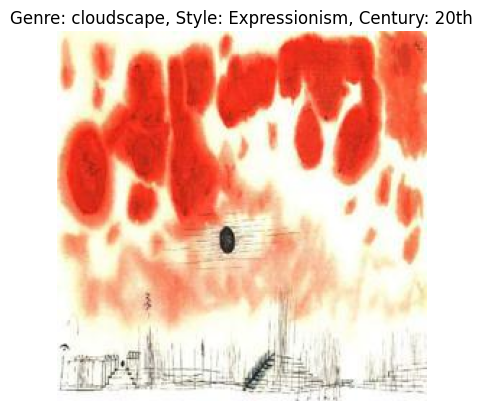

In [18]:
personalized_df = df.loc[df['genre'] == 'cloudscape']
show_image(personalized_df,1)

We can filter out genre values from the dataframe based on their frequencies. Any genre with a frequency less than or equal to 92 can be removed.

In [19]:
df = remove_outliers(df, 'genre',92)

Removed 465 elements based on genre threshold:
@ 1st element:- style: 'Shin-hanga' , genre: 'bijinga', century: 'bijinga'
@ 2nd element:- style: 'Byzantine' , genre: 'miniature', century: 'miniature'
@ 3rd element:- style: 'Symbolism' , genre: 'pastorale', century: 'pastorale'
@ 4th element:- style: 'Ukiyo-e' , genre: 'yakusha-e', century: 'yakusha-e'
@ 5th element:- style: 'Shin-hanga' , genre: 'yakusha-e', century: 'yakusha-e'
@ 6th element:- style: 'Shin-hanga' , genre: 'yakusha-e', century: 'yakusha-e'
@ 7th element:- style: 'Ukiyo-e' , genre: 'yakusha-e', century: 'yakusha-e'
@ 8th element:- style: 'Realism' , genre: 'pastorale', century: 'pastorale'
@ 9th element:- style: 'Realism' , genre: 'pastorale', century: 'pastorale'
@ 10th element:- style: 'Realism' , genre: 'pastorale', century: 'pastorale'
@ 11th element:- style: 'Romanticism' , genre: 'quadratura', century: 'quadratura'
@ 12th element:- style: 'Baroque' , genre: 'panorama', century: 'panorama'
@ 13th element:- style: '

In [20]:
plot_histo(df,'genre')

### Style Feature

In [21]:
plot_histo(df1_with_centuries, 'style')

We can remove all those style values having frequency less then 129.

In [22]:
df = remove_outliers(df, 'style',129)

Removed 2986 elements based on style threshold:
@ 1st element:- style: 'Divisionism' , genre: 'religious painting', century: 'Divisionism'
@ 2nd element:- style: 'Neo-Dada' , genre: 'portrait', century: 'Neo-Dada'
@ 3rd element:- style: 'Neo-Rococo' , genre: 'portrait', century: 'Neo-Rococo'
@ 4th element:- style: 'Gongbi' , genre: 'genre painting', century: 'Gongbi'
@ 5th element:- style: 'Modernismo' , genre: 'portrait', century: 'Modernismo'
@ 6th element:- style: 'Intimism' , genre: 'interior', century: 'Intimism'
@ 7th element:- style: 'Purism' , genre: 'cityscape', century: 'Purism'
@ 8th element:- style: 'Action painting' , genre: 'abstract', century: 'Action painting'
@ 9th element:- style: 'Native Art' , genre: 'abstract', century: 'Native Art'
@ 10th element:- style: 'Neo-baroque' , genre: 'still life', century: 'Neo-baroque'
@ 11th element:- style: 'Conceptual Art' , genre: 'figurative', century: 'Conceptual Art'
@ 12th element:- style: 'Biedermeier' , genre: 'portrait', cen

In [23]:
plot_histo(df,'style')

In [24]:
print(f"Final DataFrame Shape: {df.shape}")
df.head()

Final DataFrame Shape: (72317, 5)


genre          style    filename  \
0           cityscape    New Realism       0.jpg   
1          figurative     Surrealism  100000.jpg   
2      genre painting  Expressionism  100005.jpg   
3       self-portrait  Expressionism  100061.jpg   
5  religious painting      Symbolism  100054.jpg   

                                               image century  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th  
5  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    20th

In [25]:
#Save images to the image_folder

def save_images_to_folder(df, image_column, filename_column, folder_path):
    """
    Save images to a specified folder.

    Args:
        df (pd.DataFrame): DataFrame containing the images.
        image_column (str): Column name for the image byte data.
        filename_column (str): Column name for the filenames.
        folder_path (str): Path to the folder where images will be saved.
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for idx, row in df.iterrows():
        image_data = row[image_column]['bytes']
        filename = row[filename_column]
        image_path = os.path.join(folder_path, filename)

        # Save the image
        with open(image_path, 'wb') as f:
            f.write(image_data)

def update_dataframe_with_paths(df, filename_column, folder_path):
    """
    Update the DataFrame to include file paths instead of byte data.

    Args:
        df (pd.DataFrame): DataFrame containing the images.
        filename_column (str): Column name for the filenames.
        folder_path (str): Path to the folder where images are saved.

    Returns:
        pd.DataFrame: Updated DataFrame with file paths.
    """
    df['image_path'] = df[filename_column].apply(lambda x: os.path.join(folder_path, x))

    return df.drop(columns=['image','filename'])

save_images_to_folder(df, 'image', 'filename', 'image_folder')
df = update_dataframe_with_paths(df, 'filename', 'image_folder')

df.head()

genre          style century               image_path
0           cityscape    New Realism    20th       image_folder/0.jpg
1          figurative     Surrealism    20th  image_folder/100000.jpg
2      genre painting  Expressionism    20th  image_folder/100005.jpg
3       self-portrait  Expressionism    20th  image_folder/100061.jpg
5  religious painting      Symbolism    20th  image_folder/100054.jpg

In [28]:
def label2id(column_values):
    mapping = {value: idx for idx, value in enumerate(column_values.unique())}
    return mapping

label2id_genre = label2id(df['genre'])
label2id_style = label2id(df['style'])
label2id_century = label2id(df['century'])


print(label2id_century)
print(label2id_genre)
print(label2id_style)

{'20th': 0, '19th': 1, '18th': 2, '14th': 3, '17th': 4, '16th': 5, '15th': 6, '21st': 7}
{'cityscape': 0, 'figurative': 1, 'genre painting': 2, 'self-portrait': 3, 'religious painting': 4, 'landscape': 5, 'portrait': 6, 'marina': 7, 'symbolic painting': 8, 'sketch and study': 9, 'design': 10, 'nude painting (nu)': 11, 'veduta': 12, 'illustration': 13, 'abstract': 14, 'capriccio': 15, 'flower painting': 16, 'animal painting': 17, 'battle painting': 18, 'still life': 19, 'mythological painting': 20, 'allegorical painting': 21, 'history painting': 22, 'interior': 23, 'cloudscape': 24, 'tessellation': 25, 'poster': 26, 'literary painting': 27, 'wildlife painting': 28, 'caricature': 29}
{'New Realism': 0, 'Surrealism': 1, 'Expressionism': 2, 'Symbolism': 3, 'Realism': 4, 'Romanticism': 5, 'Post-Impressionism': 6, 'Art Nouveau (Modern)': 7, 'Impressionism': 8, 'Baroque': 9, 'Naïve Art (Primitivism)': 10, 'Fauvism': 11, 'Pointillism': 12, 'Pop Art': 13, 'Abstract Expressionism': 14, 'Art Info

In [40]:
def id2label(id, label_mapping):
    for label, idx in label_mapping.items():
        if idx == id:
            return label
    return None

print(id2label(0,label2id_century))

20th


In [29]:
class WikiArtClassificationDataset(Dataset):
    def __init__(self, dataframe, label2id_genre, label2id_style, label2id_century, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label2id_genre = label2id_genre
        self.label2id_style = label2id_style
        self.label2id_century = label2id_century

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        genre = row['genre']
        style = row['style']
        century = row['century']

        genre_label = self.label2id_genre[genre]
        style_label = self.label2id_style[style]
        century_label = self.label2id_century[century]

        labels = {
            'genre': genre_label,
            'style': style_label,
            'century': century_label
        }

        return image, labels

In [30]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



wikiart_classification_dataset = WikiArtClassificationDataset(
    dataframe=df,
    label2id_genre=label2id_genre,
    label2id_style=label2id_style,
    label2id_century=label2id_century,
    transform=transform
)



In [31]:
train_size = int(0.6 * len(wikiart_classification_dataset))
val_size = int(0.2 * len(wikiart_classification_dataset))
test_size = len(wikiart_classification_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    wikiart_classification_dataset, [train_size, val_size, test_size]
)

In [32]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

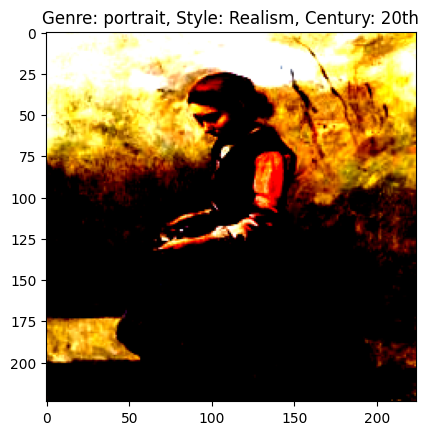

In [52]:
def show_single_element(dataloader):
    for images, labels in dataloader:
        batch_size = images.size(0)
        idx = np.random.randint(batch_size)
        genre_label = id2label(labels['genre'][idx], label2id_genre)
        style_label = id2label(labels['style'][idx], label2id_style)
        century_label = id2label(labels['century'][0], label2id_century)

        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(f"Genre: {genre_label}, Style: {style_label}, Century: {century_label}")
        plt.show()
        break


show_single_element(train_dataloader)

## Model